In [1]:
# 기본
import re
import itertools
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.externals import joblib 
from sklearn.metrics import make_scorer

# 회귀분석
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Deep Neural Network
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
# from keras.layers.recurrent import LSTM
# from keras.models import Sequential
# import time


# 인코딩
from sklearn.preprocessing import LabelEncoder
# 설정
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format



/home/sundooedu/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [3]:
data = pd.read_csv('201901-202003.csv')

In [4]:
data = data.fillna('') # Null에 ''로 채워넣음

In [5]:
data.isnull().sum()

REG_YYMM        0
CARD_SIDO_NM    0
CARD_CCG_NM     0
STD_CLSS_NM     0
HOM_SIDO_NM     0
HOM_CCG_NM      0
AGE             0
SEX_CTGO_CD     0
FLC             0
CSTMR_CNT       0
AMT             0
CNT             0
dtype: int64

In [6]:
data

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3
...,...,...,...,...,...,...,...,...,...,...,...,...
24697787,202003,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4
24697788,202003,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3
24697789,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6
24697790,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6


In [7]:
# 날짜 처리
data = data.fillna('') # Null에 ''로 채워넣음
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)

In [8]:
# 데이터 정제
df = data.copy()
df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1) # 시군구에 대한 데이터 드랍
#columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
#columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'REG_YYMM']
df = df.groupby(columns).sum().reset_index(drop=False)


In [9]:
df.describe()

,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT
count,1057394.00000,1057394.00000,1057394.00000,1057394.00000,1057394.00000,1057394.00000,1057394.00000
mean,1.44486,2.84399,2019.17713,5.71534,1447.41349,57023235.47231,2944.06108
std,0.49695,1.37150,0.38178,3.59681,11216.15206,476574321.54572,27674.18655
min,1.00000,1.00000,2019.00000,1.00000,3.00000,800.00000,1.00000
25%,1.00000,2.00000,2019.00000,2.00000,7.00000,235700.00000,10.00000
50%,1.00000,3.00000,2019.00000,5.00000,30.00000,1144865.00000,43.00000
75%,2.00000,4.00000,2019.00000,9.00000,193.00000,7827327.50000,295.00000
max,2.00000,5.00000,2020.00000,12.00000,649192.00000,34925518737.00000,2134015.00000


In [10]:
# 인코딩
# data type이 object 일 때 encoder로 숫자를 부여 해준다.
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

In [11]:
df

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT
0,강원,건강보조식품 소매업,강원,20s,1,1,2019,1,4,311200,4
1,강원,건강보조식품 소매업,강원,20s,1,1,2019,2,3,605000,3
2,강원,건강보조식품 소매업,강원,20s,1,1,2019,6,3,139000,3
3,강원,건강보조식품 소매업,강원,20s,1,1,2019,8,3,27500,3
4,강원,건강보조식품 소매업,강원,20s,1,1,2019,9,3,395500,3
...,...,...,...,...,...,...,...,...,...,...,...
1057389,충북,휴양콘도 운영업,충북,70s,2,5,2019,3,3,148000,4
1057390,충북,휴양콘도 운영업,충북,70s,2,5,2019,5,5,329800,7
1057391,충북,휴양콘도 운영업,충북,70s,2,5,2019,10,7,557800,7
1057392,충북,휴양콘도 운영업,충북,70s,2,5,2019,12,3,247800,3


In [82]:
x = df_num.drop(['AMT','CSTMR_CNT','CNT'],axis=1)
#x = df_num.drop(['AMT','CSTMR_CNT','CNT','year','month'],axis=1)
#x = df_num.drop(['AMT','AGE','SEX_CTGO_CD','FLC','HOM_SIDO_NM','CSTMR_CNT','CNT'],axis=1)
y = np.log1p(df_num['AMT'])

In [83]:
x_test,x_train,y_test,y_train = train_test_split(x,y,test_size=0.04)

# neural Network

In [56]:
#regular = 0.1

In [84]:
model= tf.keras.Sequential()

In [85]:
model.add(layers.Input(shape=x_train.shape[1]))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.2))


model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.2))


model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.2))


model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.2))


model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.2))


model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu',
                     # kernel_regularizer=tf.keras.regularizers.l2(regular),
                     # activity_regularizer=tf.keras.regularizers.l2(regular)
                      ))

model.add(Dropout(0.5))


model.add(layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(lr =0.003),loss='mean_squared_logarithmic_error',metrics=['mean_squared_logarithmic_error'])

In [86]:
hist = model.fit(x_train,y_train,epochs=20 , batch_size = 516 , validation_split =0.3)

Epoch 1/20
58/58 [==============================] - 1s 21ms/step - loss: 0.3279 - mean_squared_logarithmic_error: 0.3279 - val_loss: 0.3122 - val_mean_squared_logarithmic_error: 0.3122
Epoch 2/20
58/58 [==============================] - 1s 15ms/step - loss: 0.0626 - mean_squared_logarithmic_error: 0.0626 - val_loss: 0.3644 - val_mean_squared_logarithmic_error: 0.3644
Epoch 3/20
58/58 [==============================] - 1s 14ms/step - loss: 0.0546 - mean_squared_logarithmic_error: 0.0546 - val_loss: 0.3180 - val_mean_squared_logarithmic_error: 0.3180
Epoch 4/20
58/58 [==============================] - 1s 15ms/step - loss: 0.0496 - mean_squared_logarithmic_error: 0.0496 - val_loss: 0.3733 - val_mean_squared_logarithmic_error: 0.3733
Epoch 5/20
58/58 [==============================] - 1s 15ms/step - loss: 0.0471 - mean_squared_logarithmic_error: 0.0471 - val_loss: 0.2094 - val_mean_squared_logarithmic_error: 0.2094
Epoch 6/20
58/58 [==============================] - 1s 17ms/step - loss: 0.

In [87]:
model.evaluate(x_test,y_test, batch_size=516)

1968/1968 [==============================] - 7s 4ms/step - loss: 0.0262 - mean_squared_logarithmic_error: 0.0262


[0.0262133851647377, 0.0262133851647377]

In [88]:
hist.history.keys()

dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])

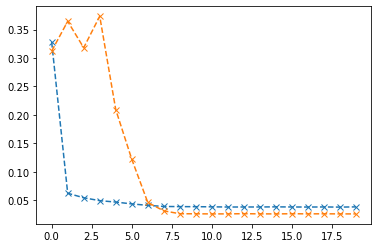

In [89]:
plt.plot(hist.history['mean_squared_logarithmic_error'],'x--')
plt.plot(hist.history['val_mean_squared_logarithmic_error'],'x--')

# randomforest

In [112]:
from sklearn.ensemble import RandomForestRegressor

In [161]:
params= {'n_estimators' : [1,10,100,1000,2000],        
        'max_depth' : [10,8,6,4,2],
        'max_features' : ["sqrt",'log2']
        }

In [162]:
grid = GridSearchCV(RandomForestRegressor(),param_grid=params,refit=True,verbose=True)
grid.fit(x_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 20.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [163]:
grid.best_params_

{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 2000}

In [164]:
rf = RandomForestRegressor(max_depth =10, max_features='log2', n_estimators= 2000)

In [165]:
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [166]:
rf.score(x_test,y_test)

0.2599439965789231

In [168]:
pred = rf.predict(x_test)
pred

array([14.46698521, 13.31833111, 12.87388405, ..., 14.60555308,
       15.53666695, 13.88599645])

In [169]:
from sklearn import metrics
metrics.r2_score(y_test,pred)

0.2599439965789231

In [170]:
metrics.mean_squared_error(y_test,pred)

4.658291539193871

# One hot encoding

In [28]:
df_1hot = pd.get_dummies(df,columns = ['year','month','SEX_CTGO_CD','CARD_SIDO_NM','STD_CLSS_NM', 'HOM_SIDO_NM','AGE'])
df_1hot

,FLC,CSTMR_CNT,AMT,CNT,year_2019,year_2020,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,SEX_CTGO_CD_1,SEX_CTGO_CD_2,CARD_SIDO_NM_강원,CARD_SIDO_NM_경기,CARD_SIDO_NM_경남,CARD_SIDO_NM_경북,CARD_SIDO_NM_광주,CARD_SIDO_NM_대구,CARD_SIDO_NM_대전,CARD_SIDO_NM_부산,CARD_SIDO_NM_서울,CARD_SIDO_NM_세종,CARD_SIDO_NM_울산,CARD_SIDO_NM_인천,CARD_SIDO_NM_전남,CARD_SIDO_NM_전북,CARD_SIDO_NM_제주,CARD_SIDO_NM_충남,CARD_SIDO_NM_충북,STD_CLSS_NM_건강보조식품 소매업,STD_CLSS_NM_골프장 운영업,STD_CLSS_NM_과실 및 채소 소매업,STD_CLSS_NM_관광 민예품 및 선물용품 소매업,STD_CLSS_NM_그외 기타 분류안된 오락관련 서비스업,STD_CLSS_NM_그외 기타 스포츠시설 운영업,STD_CLSS_NM_그외 기타 종합 소매업,STD_CLSS_NM_기타 대형 종합 소매업,STD_CLSS_NM_기타 수상오락 서비스업,STD_CLSS_NM_기타 외국식 음식점업,STD_CLSS_NM_기타 주점업,STD_CLSS_NM_기타음식료품위주종합소매업,STD_CLSS_NM_내항 여객 운송업,STD_CLSS_NM_마사지업,STD_CLSS_NM_면세점,STD_CLSS_NM_버스 운송업,STD_CLSS_NM_비알콜 음료점업,STD_CLSS_NM_빵 및 과자류 소매업,STD_CLSS_NM_서양식 음식점업,STD_CLSS_NM_수산물 소매업,STD_CLSS_NM_슈퍼마켓,STD_CLSS_NM_스포츠 및 레크레이션 용품 임대업,STD_CLSS_NM_여관업,STD_CLSS_NM_여행사업,STD_CLSS_NM_욕탕업,STD_CLSS_NM_육류 소매업,STD_CLSS_NM_일반유흥 주점업,STD_CLSS_NM_일식 음식점업,STD_CLSS_NM_자동차 임대업,STD_CLSS_NM_전시 및 행사 대행업,STD_CLSS_NM_정기 항공 운송업,STD_CLSS_NM_중식 음식점업,STD_CLSS_NM_차량용 가스 충전업,STD_CLSS_NM_차량용 주유소 운영업,STD_CLSS_NM_체인화 편의점,STD_CLSS_NM_택시 운송업,STD_CLSS_NM_피자 햄버거 샌드위치 및 유사 음식점업,STD_CLSS_NM_한식 음식점업,STD_CLSS_NM_호텔업,STD_CLSS_NM_화장품 및 방향제 소매업,STD_CLSS_NM_휴양콘도 운영업,HOM_SIDO_NM_강원,HOM_SIDO_NM_경기,HOM_SIDO_NM_경남,HOM_SIDO_NM_경북,HOM_SIDO_NM_광주,HOM_SIDO_NM_대구,HOM_SIDO_NM_대전,HOM_SIDO_NM_부산,HOM_SIDO_NM_서울,HOM_SIDO_NM_세종,HOM_SIDO_NM_울산,HOM_SIDO_NM_인천,HOM_SIDO_NM_전남,HOM_SIDO_NM_전북,HOM_SIDO_NM_제주,HOM_SIDO_NM_충남,HOM_SIDO_NM_충북,AGE_10s,AGE_20s,AGE_30s,AGE_40s,AGE_50s,AGE_60s,AGE_70s
0,1,4,311200,4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,3,605000,3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,3,139000,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,3,27500,3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,3,395500,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057389,5,3,148000,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1057390,5,5,329800,7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1057391,5,7,557800,7,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1057392,5,3,247800,3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [29]:
x = df_1hot.drop(['AMT','CSTMR_CNT','CNT'],axis=1)
y = df_1hot['AMT']

In [30]:
x_test,x_train,y_test,y_train = train_test_split(x,y,test_size=0.04)

In [31]:
model= tf.keras.Sequential()

In [32]:
model.add(layers.Input(shape=x_train.shape[1]))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.2))


model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.2))


model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.2))


model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))

model.add(Dropout(0.5))


model.add(layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(lr =0.003),loss='mean_squared_logarithmic_error',metrics=['mean_squared_logarithmic_error'])

In [33]:
hist = model.fit(x_train,y_train,epochs=20 , batch_size = 128 , validation_split =0.3)

Epoch 1/20
232/232 [==============================] - 2s 7ms/step - loss: 10.0282 - mean_squared_logarithmic_error: 10.0282 - val_loss: 5.5001 - val_mean_squared_logarithmic_error: 5.5001
Epoch 2/20
232/232 [==============================] - 1s 6ms/step - loss: 4.7338 - mean_squared_logarithmic_error: 4.7338 - val_loss: 3.3993 - val_mean_squared_logarithmic_error: 3.3993
Epoch 3/20
232/232 [==============================] - 2s 7ms/step - loss: 2.8562 - mean_squared_logarithmic_error: 2.8562 - val_loss: 2.5664 - val_mean_squared_logarithmic_error: 2.5664
Epoch 4/20
232/232 [==============================] - 2s 7ms/step - loss: 2.1444 - mean_squared_logarithmic_error: 2.1444 - val_loss: 2.0173 - val_mean_squared_logarithmic_error: 2.0173
Epoch 5/20
232/232 [==============================] - 2s 7ms/step - loss: 1.4504 - mean_squared_logarithmic_error: 1.4504 - val_loss: 1.4421 - val_mean_squared_logarithmic_error: 1.4421
Epoch 6/20
232/232 [==============================] - 2s 7ms/step - 

In [34]:
model.evaluate(x_test,y_test, batch_size=128)

7931/7931 [==============================] - 17s 2ms/step - loss: 0.9470 - mean_squared_logarithmic_error: 0.9470


[0.9470381736755371, 0.9470381736755371]

In [35]:
hist.history.keys()

dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])

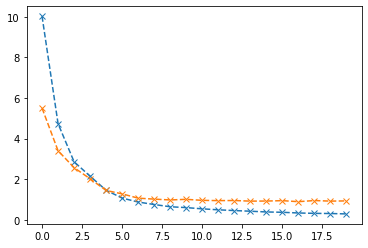

In [36]:
plt.plot(hist.history['mean_squared_logarithmic_error'],'x--')
plt.plot(hist.history['val_mean_squared_logarithmic_error'],'x--')

# 예측 템플릿 만드는법

In [171]:
CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df['HOM_SIDO_NM'].unique()
AGEs          = df['AGE'].unique()
SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
FLCs          = df['FLC'].unique()
years         = [2020]
months        = [4,7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month'])

In [172]:
temp

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month
0,강원,건강보조식품 소매업,강원,20s,1,1,2020,4
1,강원,건강보조식품 소매업,강원,20s,1,1,2020,7
2,강원,건강보조식품 소매업,강원,20s,1,2,2020,4
3,강원,건강보조식품 소매업,강원,20s,1,2,2020,7
4,강원,건강보조식품 소매업,강원,20s,1,3,2020,4
...,...,...,...,...,...,...,...,...
1658855,충북,정기 항공 운송업,제주,10s,2,3,2020,7
1658856,충북,정기 항공 운송업,제주,10s,2,4,2020,4
1658857,충북,정기 항공 운송업,제주,10s,2,4,2020,7
1658858,충북,정기 항공 운송업,제주,10s,2,5,2020,4


In [173]:
# 인코딩
# data type이 object 일 때 encoder로 숫자를 부여 해준다.
dtypes = df.dtypes
encoders = {}
for column in temp.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(temp[column])
        encoders[column] = encoder
        
temp = temp.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    temp[column] = encoder.transform(temp[column])

In [174]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015098 entries, 522563 to 859599
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype
---  ------        --------------    -----
 0   CARD_SIDO_NM  1015098 non-null  int64
 1   STD_CLSS_NM   1015098 non-null  int64
 2   HOM_SIDO_NM   1015098 non-null  int64
 3   AGE           1015098 non-null  int64
 4   SEX_CTGO_CD   1015098 non-null  int64
 5   FLC           1015098 non-null  int64
 6   year          1015098 non-null  int64
 7   month         1015098 non-null  int64
dtypes: int64(8)
memory usage: 69.7 MB


In [175]:
temp.columns

Index(['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD',
       'FLC', 'year', 'month'],
      dtype='object')

In [176]:
temp = temp[['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD','FLC', 'year', 'month']].astype('int')

In [177]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658860 entries, 0 to 1658859
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype
---  ------        --------------    -----
 0   CARD_SIDO_NM  1658860 non-null  int64
 1   STD_CLSS_NM   1658860 non-null  int64
 2   HOM_SIDO_NM   1658860 non-null  int64
 3   AGE           1658860 non-null  int64
 4   SEX_CTGO_CD   1658860 non-null  int64
 5   FLC           1658860 non-null  int64
 6   year          1658860 non-null  int64
 7   month         1658860 non-null  int64
dtypes: int64(8)
memory usage: 101.2 MB


In [178]:
pred = rf.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [104]:
# pred = model.predict(temp)
# pred = np.expm1(pred)
# temp['AMT'] = np.round(pred, 0)
# temp['REG_YYMM'] = temp['year']*100 + temp['month']
# temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
# temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [179]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [180]:
submission = pd.read_csv('submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
submission.to_csv('submission.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,1215235317.00000
1,202004,강원,골프장 운영업,1380855606.00000
2,202004,강원,과실 및 채소 소매업,1077416562.00000
3,202004,강원,관광 민예품 및 선물용품 소매업,829812850.00000
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,824422472.00000


In [181]:
pred

array([1779228.26462544, 1768120.35314141, 1642230.48193812, ...,
       1254433.12230986, 1170787.17085171, 1249398.55021559])